In [19]:
# import all necessary packages
import pandas as pd
import numpy as np
import warnings
from pandas.core.common import SettingWithCopyWarning
#warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
import matplotlib.pyplot as plt
from scipy.stats import loguniform
import predictive as pred
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [15]:
# import datasets
df_chicago = pd.read_csv("data/datasets/df_chicago.csv.zip")

In [16]:
df_chicago_cluster = df_chicago[['start_time_hourly','Trip_Seconds',"Trip_Miles"]]
df_chicago_cluster

,start_time_hourly,Trip_Seconds,Trip_Miles
0,0,900.0,2.7
1,0,240.0,0.4
2,0,1920.0,0.6
3,0,180.0,1.0
4,0,240.0,0.3
...,...,...,...
8974515,23,540.0,1.4
8974516,23,1860.0,5.9
8974517,23,720.0,2.0
8974518,23,660.0,3.5


When researching for the best score to use when deciding which number of cluster to choose for the Gaussian Mixture Model (soft-clustering), we found the Silhouette score and the Bayesian information criterion (BIC).

In [20]:
# method for scaling the data 
def scaling_data(df1):
    
    scaler = StandardScaler()
    df_chicago_scaled = scaler.fit_transform(df1)
    df_chicago_scaled = pd.DataFrame(df_chicago_scaled, columns=df1.columns, 
                                            index=df1.index)
    
    return df_chicago_scaled

In [21]:
df_cluster_scaled = scaling_data(df_chicago_cluster)

In [22]:
df_cluster_scaled

,start_time_hourly,Trip_Seconds,Trip_Miles
0,-1.963199,0.671797,0.190500
1,-1.963199,-1.103329,-0.756058
2,-1.963199,3.415174,-0.673748
3,-1.963199,-1.264704,-0.509130
4,-1.963199,-1.103329,-0.797212
...,...,...,...
8974515,1.373037,-0.296454,-0.344511
8974516,1.373037,3.253799,1.507450
8974517,1.373037,0.187672,-0.097583
8974518,1.373037,0.026297,0.519738


### Silhouette score

In [23]:
def silhoutte(input_data, num_clus):

    #input data: part of df to cluster

    clusters = []
    scores = []

    for k in range(num_clus):
        
        model_clus = GaussianMixture(n_components = k+2, n_init = 15) #defaults: init_params='kmeans'
        labels = model_clus.fit_predict(input_data)
        
        clusters.append(k+1)
        scores.append(silhouette_score(input_data, labels = labels, sample_size=1000,random_state=42))
        #defaults: metric=euclidian
        
    return clusters, scores

In [92]:
df_score = df_cluster_scaled.sample(100000, random_state=42)
df_score

,start_time_hourly,Trip_Seconds,Trip_Miles
5361192,0.067554,-0.619204,-0.467975
487735,1.082930,-1.264704,-0.714903
2121174,-1.528038,1.801423,2.700936
5764286,-0.367608,0.187672,-0.138737
1384941,1.082930,-1.103329,-0.632594
...,...,...,...
3465231,-0.077500,2.608298,-0.262201
7018767,1.373037,0.510422,-0.826021
7883645,0.067554,-0.619204,-0.426820
1829701,-0.657715,-1.103329,-0.344511


In [94]:
clusters_sil, scores_sil = silhoutte(df_score, 10)

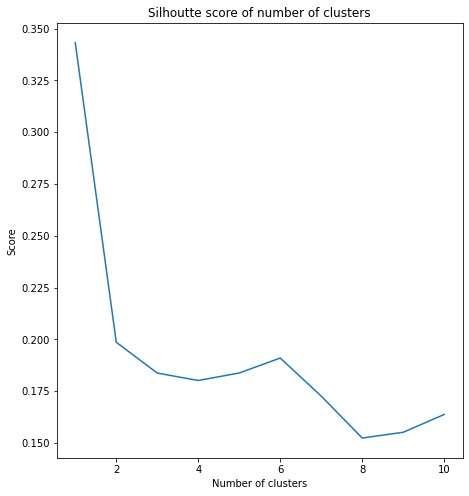

<Figure size 432x288 with 0 Axes>

In [95]:
fig = plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)

   # clusters, scores = get_clusters_and_losses(input_data)

plt.plot(clusters_sil, scores_sil)
plt.ylabel("Score")
plt.xlabel("Number of clusters")
plt.title(f"Silhoutte score of number of clusters")

plt.show()
plt.savefig('silhoutte_score')

### Bayesian information criterion (BIC)

In [96]:
def bic(input_data, num_clus):

    #input data: part of df to cluster

    clusters = []
    scores = []

    for k in range(num_clus):
        
        model_clus = GaussianMixture(n_components = k+2, n_init = 15) #defaults: init_params='kmeans'
        model_clus.fit(input_data)
        
        clusters.append(k+1)
        scores.append(model_clus.bic(input_data))

        #defaults: metric=euclidian
        
    return clusters, scores

In [97]:
clusters_bic, scores_bic = bic(df_score, 10)

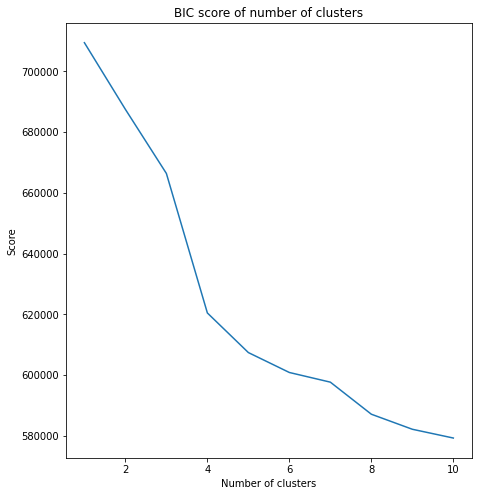

<Figure size 432x288 with 0 Axes>

In [98]:
fig = plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)

   # clusters, scores = get_clusters_and_losses(input_data)

plt.plot(clusters_bic, scores_bic)
plt.ylabel("Score")
plt.xlabel("Number of clusters")
plt.title(f"BIC score of number of clusters")

plt.show()
plt.savefig('BIC_score')

In [71]:
df_clusters = df_cluster_scaled

In [72]:
gm = GaussianMixture(n_components=6, random_state=42).fit(df_clusters)

In [73]:
cluster = gm.predict(df_clusters)

In [74]:
cluster_prob = gm.predict_proba(df_clusters)

In [75]:
df_chicago_cluster["cluster"] = cluster

/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_15837/1108605377.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chicago_cluster["cluster"] = cluster


In [76]:
for k in range(6):
    df_chicago_cluster[f"cluster_{k}_prob"] = cluster_prob[:, k]

/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_15837/968314641.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chicago_cluster[f"cluster_{k}_prob"] = cluster_prob[:, k]


In [77]:
df_chicago_cluster

,start_time_hourly,Trip_Seconds,Trip_Miles,cluster,cluster_0_prob,cluster_1_prob,cluster_2_prob,cluster_3_prob,cluster_4_prob,cluster_5_prob,cluster_6_prob,cluster_7_prob
0,0,900.0,2.7,5,2.786061e-03,7.375284e-257,2.383828e-08,0.027109,4.596722e-18,9.701053e-01,6.996105e-247,2.105519e-04
1,0,240.0,0.4,0,9.827634e-01,8.309410e-05,9.050978e-05,0.000335,4.263931e-22,1.672841e-02,3.599453e-05,5.540377e-03
2,0,1920.0,0.6,3,1.356836e-63,7.804490e-02,6.585642e-83,0.921955,1.632349e-16,1.280517e-09,7.266577e-02,2.107329e-64
3,0,180.0,1.0,0,9.930637e-01,4.364091e-39,6.748253e-07,0.000136,1.407290e-23,6.799949e-03,1.054215e-37,2.323678e-02
4,0,240.0,0.3,0,9.509023e-01,2.647352e-02,1.278652e-04,0.000470,7.313791e-22,2.202660e-02,7.267866e-03,3.657204e-03
...,...,...,...,...,...,...,...,...,...,...,...,...
8974515,23,540.0,1.4,2,1.043907e-01,1.078587e-68,7.032343e-01,0.000889,1.866669e-01,4.818878e-03,5.404980e-66,4.169559e-02
8974516,23,1860.0,5.9,3,3.767023e-18,0.000000e+00,4.801788e-29,0.999881,1.187235e-04,2.710996e-07,0.000000e+00,2.731489e-23
8974517,23,720.0,2.0,4,1.691213e-01,4.173540e-141,1.416722e-01,0.006643,6.573512e-01,2.521251e-02,8.829430e-136,1.642763e-02
8974518,23,660.0,3.5,4,1.058956e-05,0.000000e+00,2.983564e-06,0.005941,9.821831e-01,1.186249e-02,0.000000e+00,1.776869e-08


In [78]:
def plot_information_about_clusters(df, feature_list, cluster_column):
    
    fig = plt.figure(figsize=(14, 18))
    
    for i in range(1, len(feature_list)+1):
        plt.subplot(np.floor(len(feature_list)/2).astype(int)+1, 2, i)
        sns.boxplot(y=df[feature_list[i-1]], 
                    x = df[cluster_column], 
                    palette="bright",
                    showmeans=True,
                    meanprops={"marker": "+",
                       "markeredgecolor": "black",
                       "markersize": "10"}).set_title("Cluster - " + feature_list[i-1]).set_fontsize('18')
        plt.tight_layout()
    
    plt.subplot(np.floor(len(feature_list)/2).astype(int)+1, 2, len(feature_list)+1)
    ax = sns.countplot(x=cluster_column, data=df, palette="bright")
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Amount")
    ax.set_title('Cluster - Amount',fontsize=18)
    fig.tight_layout()

    for container in ax.containers:
        ax.bar_label(container)

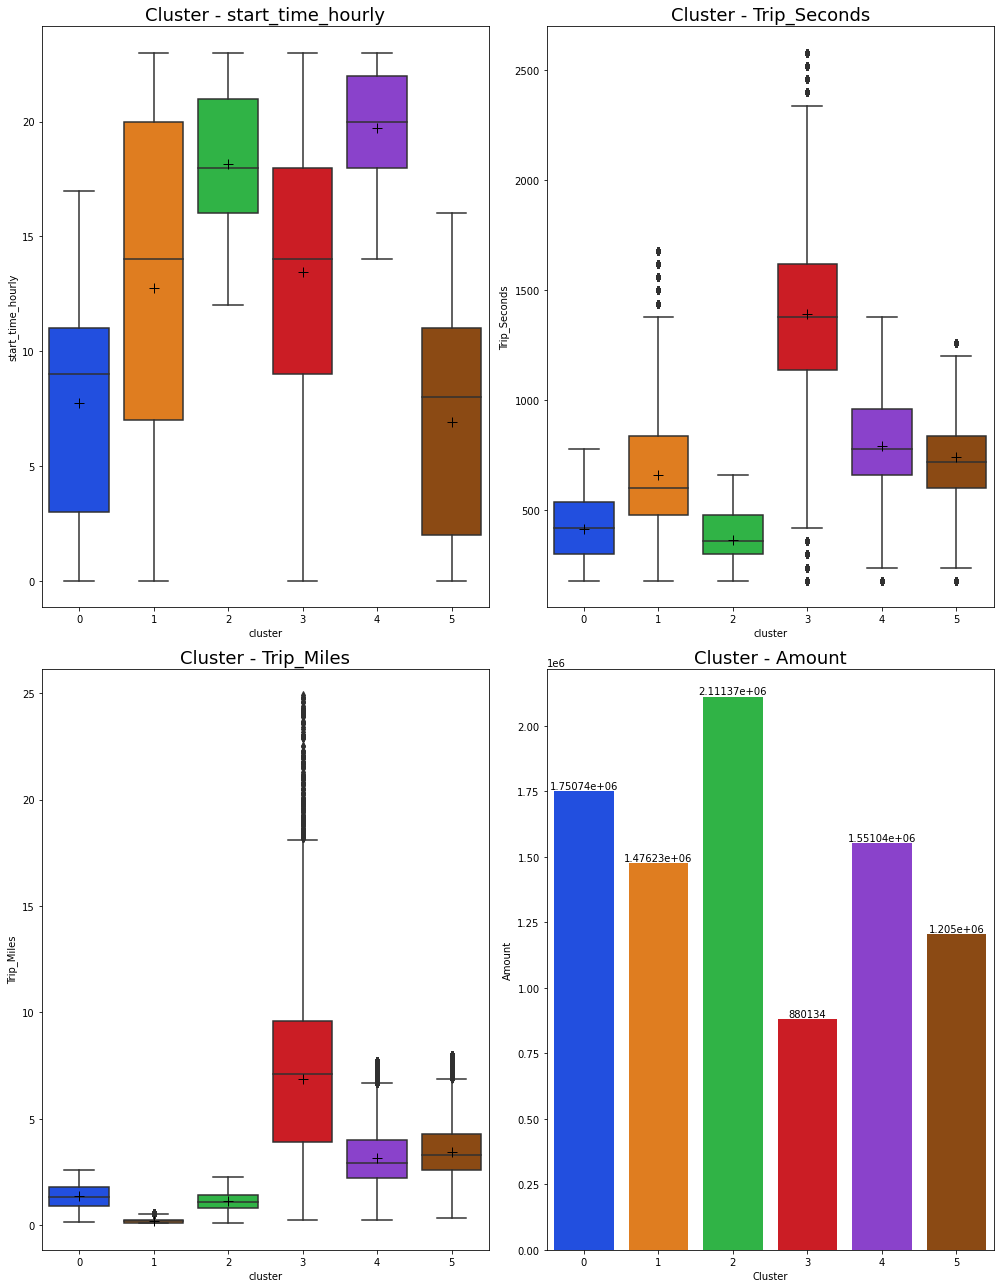

In [79]:
plot_information_about_clusters(df_chicago_cluster, ['start_time_hourly', 'Trip_Seconds', 'Trip_Miles'], 'cluster')

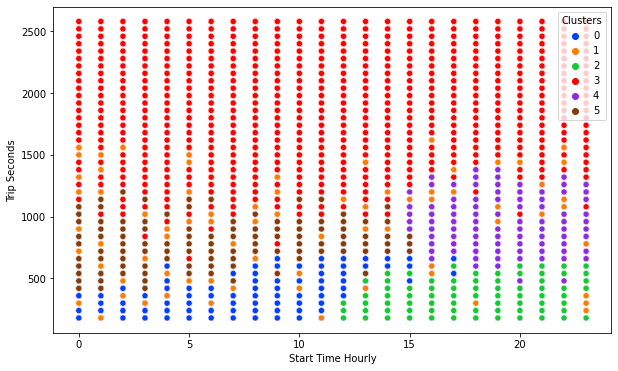

In [89]:
colors = {
    2: '#16C835', #green
    1: '#FF7C00',#orange
    4: '#8B2BE2',#violet
    5: '#843C0C',#brown
    0: '#023EFF',#blue
    6: '#FF1493',#rosa
    3:'#FF0000',#red
    7:'#808080'#grey
    # Add more colors for other clusters if needed
}

# Create the scatter plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Use hue parameter to color the data points based on the 'cluster' column
sns.scatterplot(x='start_time_hourly', y='Trip_Seconds', data=df_chicago_cluster, hue='cluster', palette=colors)

# Add labels and legend
plt.xlabel('Start Time Hourly')
plt.ylabel('Trip Seconds')
plt.legend(title='Clusters', loc='upper right')

# Show the plot
plt.show()

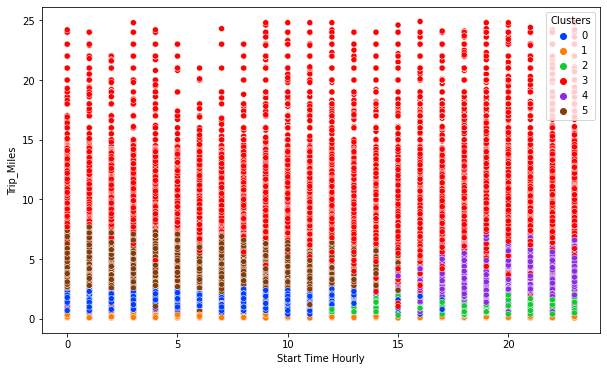

In [90]:
colors = {
    2: '#16C835', #green
    1: '#FF7C00',#orange
    4: '#8B2BE2',#violet
    5: '#843C0C',#brown
    0: '#023EFF',#blue
    6: '#FF1493',#rosa
    3:'#FF0000',#red
    7:'#808080'#grey
    # Add more colors for other clusters if needed
}

# Create the scatter plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Use hue parameter to color the data points based on the 'cluster' column
sns.scatterplot(x='start_time_hourly', y='Trip_Miles', data=df_chicago_cluster, hue='cluster', palette=colors)

# Add labels and legend
plt.xlabel('Start Time Hourly')
plt.ylabel('Trip_Miles')
plt.legend(title='Clusters', loc='upper right')

# Show the plot
plt.show()

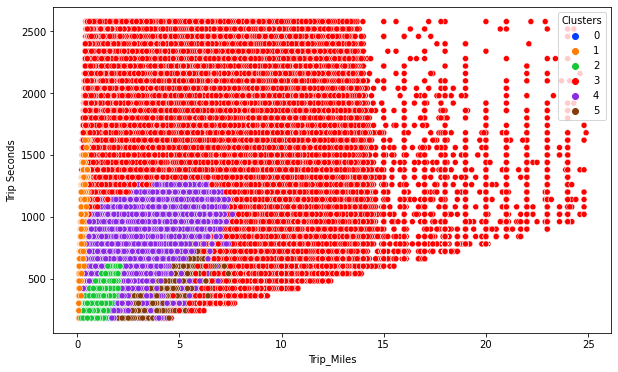

In [91]:
colors = {
    2: '#16C835', #green
    1: '#FF7C00',#orange
    4: '#8B2BE2',#violet
    5: '#843C0C',#brown
    0: '#023EFF',#blue
    6: '#FF1493',#rosa
    3:'#FF0000',#red
    7:'#808080'#grey
    # Add more colors for other clusters if needed
}

# Create the scatter plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Use hue parameter to color the data points based on the 'cluster' column
sns.scatterplot(x='Trip_Miles', y='Trip_Seconds', data=df_chicago_cluster, hue='cluster', palette=colors)

# Add labels and legend
plt.xlabel('Trip_Miles')
plt.ylabel('Trip Seconds')
plt.legend(title='Clusters', loc='upper right')

# Show the plot
plt.show()

In [ ]:
df_chicago['chicago_center'] = [41.881832, -87.623177]

In [ ]:
df_chicago["dist_center_pick"] = df_chicago.apply(lambda row: haversine(row["Pickup_Centroid_Location"], row["end"]), axis=1)
df_chicago["dist_center_drop"] = df_chicago.apply(lambda row: haversine(row["Dropoff_Centroid_Location"], row["end"]), axis=1)
df_chicago[["start", "end", "distance (km)"]]

In [ ]:
df_location = df_chicago['Pickup_Community_Area','Pickup_Centroid_Location',]